In [22]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from sklearn.model_selection import train_test_split
import math

In [23]:
# Step 1: Load the CSV dataset
def load_data(csv_path):
    data = pd.read_csv(csv_path, low_memory=False)
    data = data.sample(frac=0.01, random_state=42)  # Shuffle data
    return data

# Step 2: Convert numerical features to grayscale images
def convert_to_image(data, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    # Identify the label column dynamically
    label_col = None
    for col in data.columns:
        if "label" in col.lower() or "class" in col.lower() or "attack" in col.lower():
            label_col = col
            break

    if label_col is None:
        raise ValueError("No label column found in dataset. Check column names!")

    # Extract feature columns (excluding the label)
    feature_columns = data.select_dtypes(include=[np.number]).columns.tolist()
    if label_col in feature_columns:
        feature_columns.remove(label_col)

    print(f"Using label column: {label_col}")  # Debugging output

    # Ensure all feature columns are numeric and fill NaN values
    data[feature_columns] = data[feature_columns].apply(pd.to_numeric, errors='coerce')
    data[feature_columns] = data[feature_columns].fillna(0)  # Fill NaNs with 0

    images, labels = [], []
    num_features = len(feature_columns)
    image_size = math.ceil(math.sqrt(num_features))  # Find the next perfect square

    for i, row in enumerate(data.iterrows()):
        features = row[1][feature_columns].values
        
        # Normalize features to [0, 1] range
        min_features = np.min(features)
        max_features = np.max(features)
        
        # Avoid division by zero if max == min
        if max_features != min_features:
            normalized_features = (features - min_features) / (max_features - min_features)
        else:
            normalized_features = np.zeros_like(features)  # All values are the same, set to 0

        # Scale features to [0, 255] and convert to uint8
        scaled_features = (normalized_features * 255).astype(np.uint8)
        
        # Reshape into a square image
        padded_features = np.pad(scaled_features, (0, image_size**2 - num_features), 'constant')
        image_matrix = padded_features.reshape(image_size, image_size)

        # Convert to image
        img = Image.fromarray(image_matrix, mode='L')
        image_path = os.path.join(save_dir, f"{i}.png")
        img.save(image_path)

        # Append image path and label
        images.append(image_path)
        labels.append(row[1][label_col])

    return images, labels

# Step 3: Create custom dataset class
class DDoSDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
        # Create a dynamic label-to-index mapping
        self.label_map = {label: idx for idx, label in enumerate(sorted(set(labels)))}
        
        # Debugging: Print out the label mapping to ensure it's correct
        print(f"Label mapping: {self.label_map}")
        
        # Store the number of classes dynamically
        self.num_classes = len(self.label_map)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img = Image.open(self.image_paths[idx])

        # Convert grayscale to RGB if the image is in grayscale
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Get the label and map it to integer (dynamic number of classes)
        label = self.labels[idx]
        label = self.label_map[label]  # Convert the label to an integer

        # Apply transformations if any
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label)

# Step 4: Define transformations for images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to fixed size
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize if needed
])

In [24]:
# Step 5: Load the data and convert to images
train_val_data = load_data("/Users/book_kuno/Desktop/DDoS 2018/02-21-2018.csv")
test_data = load_data("/Users/book_kuno/Desktop/DDoS 2018/02-21-2018.csv")

train_val_image_paths, train_val_labels = convert_to_image(train_val_data, "./train_val_images")
test_image_paths, test_labels = convert_to_image(test_data, "./test_images")

# Step 6: Split the training/validation dataset into train and validation sets
train_feats, val_feats, train_labels, val_labels = train_test_split(
    train_val_image_paths, train_val_labels, test_size=0.3, random_state=42
)

# Step 7: Create datasets and dataloaders
train_dataset = DDoSDataset(train_feats, train_labels, transform)
val_dataset = DDoSDataset(val_feats, val_labels, transform)
test_dataset = DDoSDataset(test_image_paths, test_labels, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Using label column: Label
Using label column: Label
Label mapping: {'Benign': 0, 'DDOS attack-HOIC': 1, 'DDOS attack-LOIC-UDP': 2}
Label mapping: {'Benign': 0, 'DDOS attack-HOIC': 1, 'DDOS attack-LOIC-UDP': 2}
Label mapping: {'Benign': 0, 'DDOS attack-HOIC': 1, 'DDOS attack-LOIC-UDP': 2}


In [25]:
# Step 8: Load pre-trained ResNet-18 and modify it for dynamic number of classes
model = models.resnet18(pretrained=True) #modeify if want to custom the parameters?
# Assuming you have train_labels defined in your dataset after splitting
num_classes = len(set(train_labels))  # Get the number of unique classes from training labels
num_features = model.fc.in_features  # Get the number of input features for the last layer

# Modify the fully connected layer to handle a dynamic number of classes
model.fc = nn.Linear(num_features, num_classes)  # Modify the output layer to match the number of classes
model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Define the device (CUDA or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 9: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 10: Define transformations (including resizing and normalization for ResNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for ResNet
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

/Users/book_kuno/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/book_kuno/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TRAINING

In [26]:
# Step 11: Train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation step
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():  # Disable gradient calculation for validation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()  # Calculate validation loss
                _, predicted = torch.max(outputs, 1)  # Get predicted class labels
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate validation accuracy
        val_accuracy = 100 * correct / total
        
        # Print loss and accuracy for both training and validation
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {total_loss/len(train_loader):.4f}, "
              f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return model

# Train the model with validation
model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=3)

Epoch 1/3, Training Loss: 0.0296, Validation Loss: 0.0011, Validation Accuracy: 99.97%
Epoch 2/3, Training Loss: 0.0024, Validation Loss: 0.0003, Validation Accuracy: 99.97%
Epoch 3/3, Training Loss: 0.0004, Validation Loss: 0.0189, Validation Accuracy: 99.81%


WITH HYPERPARAMETERS TUNING

In [27]:
# import optuna
# import torch
# from sklearn.metrics import accuracy_score

# # Step 11: Train the model with hyperparameter optimization

# # Step 11.1: Define the training function
# def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
#     model.train()  # Set model to training mode
#     for epoch in range(epochs):
#         total_loss = 0
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()

#         # Validation step
#         model.eval()  # Set model to evaluation mode
#         val_loss = 0
#         correct = 0
#         total = 0
#         with torch.no_grad():  # Disable gradient calculation for validation
#             for images, labels in val_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 val_loss += criterion(outputs, labels).item()  # Calculate validation loss
#                 _, predicted = torch.max(outputs, 1)  # Get predicted class labels
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         # Calculate validation accuracy
#         val_accuracy = 100 * correct / total
#         print(f"Epoch {epoch+1}/{epochs}, Training Loss: {total_loss/len(train_loader):.4f}, "
#               f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
#     return model, val_accuracy

# # Step 11.2: Define the objective function for Optuna
# def objective(trial):
#     # Hyperparameter optimization space
#     learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-1)  # Learning rate range: 1e-5 to 1e-1
#     batch_size = trial.suggest_int('batch_size', 16, 128, step=16)  # Batch size range: 16 to 128
#     epochs = trial.suggest_int('epochs', 1, 2)  # Given: Epochs range: 5 to 20

#     # Update your DataLoader with the suggested batch size
#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
#     # Model setup
#     model = models.resnet18(pretrained=True)
#     num_features = model.fc.in_features
#     model.fc = nn.Linear(num_features, len(set(labels)))  # Modify output layer for dynamic classes
#     model = model.to(device)
    
#     # Optimizer setup
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     criterion = nn.CrossEntropyLoss()
    
#     # Train the model and evaluate on validation set
#     model, val_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)
    
#     return val_accuracy  # Return validation accuracy for Optuna to optimize

In [28]:
# # Step 11.3: Hyperparameter optimization with Optuna
# study = optuna.create_study(direction='maximize')  # Maximize validation accuracy
# study.optimize(objective, n_trials=2)  # Given: Run 10 trials

# # Print the best hyperparameters
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

In [29]:
# # Step 11.4: Retrain the model with the best hyperparameters
# learning_rate = best_params['lr']
# batch_size = best_params['batch_size']
# epochs = best_params['epochs']

# # Update your DataLoader with the best batch_size
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# # Define your model again and set the optimizer with the best learning rate
# model = models.resnet18(pretrained=True)
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, len(set(labels)))  # Modify output layer for dynamic classes
# model = model.to(device)

# # Set the optimizer with the best learning rate
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
# # Step 11.5: Train the model with the best hyperparameters
# model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs)[0]

TESTING

In [31]:
# Step 12: Evaluate on test data
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []  # To store true labels
    y_pred = []  # To store predicted labels
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Append the current batch's true and predicted labels to the lists
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return y_true, y_pred

# Get the true and predicted labels
y_true, y_pred = evaluate_model(model, test_loader)


Test Accuracy: 99.81%


<!-- 
Todo:
1)Add validation step (in/after training)
2)Visulaiations on the performance 
3)Parameters of resnet18

Todo: 2 datasets
1)two datasets version

Todo: Metrics
1)Performamce Metric
2)Resource Efficiency Metrics
-->

In [32]:
#V1:Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3573
           1       1.00      1.00      1.00      6896
           2       0.46      1.00      0.63        17

    accuracy                           1.00     10486
   macro avg       0.82      1.00      0.88     10486
weighted avg       1.00      1.00      1.00     10486



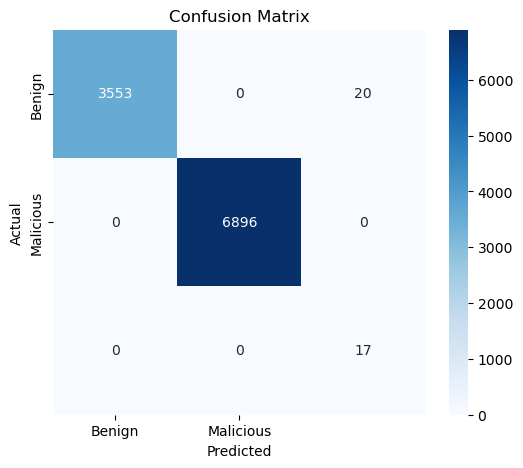

In [33]:
#V2:Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have already obtained y_true and y_pred from the evaluate_model function
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious']) #Edit this to use the actual labels from the loaded dataset

# Adding labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

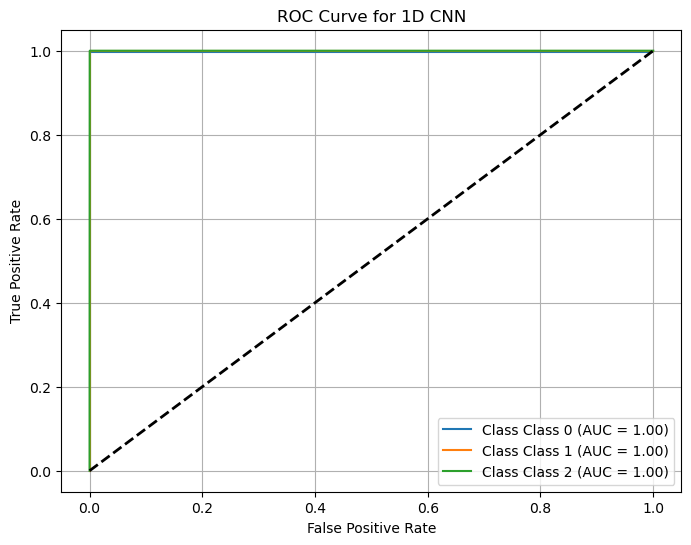

In [34]:
#V3: ROC Curve
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a trained model 'cnn_model' and test data loaded in 'test_loader'
# 'y_true' corresponds to the ground truth labels for the test set.
# 'y_pred_prob' corresponds to the predicted probabilities from your CNN model.

def get_predictions_and_probabilities(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred_prob = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Get model predictions (logits)
            prob = torch.nn.functional.softmax(outputs, dim=1)  # Apply softmax to get probabilities

            y_true.extend(labels.cpu().numpy())  # Convert to CPU and append to y_true list
            y_pred_prob.extend(prob.cpu().numpy())  # Convert to CPU and append to predicted probabilities

    # Convert y_pred_prob list to a NumPy array
    y_pred_prob = np.array(y_pred_prob)

    return y_true, y_pred_prob

# Get true labels and predicted probabilities
y_true, y_pred_prob = get_predictions_and_probabilities(model, test_loader, device)

# Plot ROC curves for each class
class_names = ['Class 0', 'Class 1', 'Class 2']  # Modify this to your class names
plt.figure(figsize=(8, 6))

# Loop over each class and calculate the ROC curve
for i in range(y_pred_prob.shape[1]):  # Loop over each class
    fpr, tpr, _ = roc_curve(np.array(y_true) == i, y_pred_prob[:, i])  # Calculate ROC curve
    roc_auc = auc(fpr, tpr)  # Calculate AUC
    plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC = {roc_auc:.2f})")  # Plot the ROC curve for each class

plt.plot([0, 1], [0, 1], "k--", lw=2)  # Diagonal line (random classifier)
plt.title("ROC Curve for 1D CNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.grid()
plt.show()